### 数据说明

使用python自带的经典MNIST手写数据集。该数据集包含60000个训练样本及10000个测试样本。数据集中的数字（0-9）已经规范为固定28x28 pixels的像素大小。
为了方便建模处理，每张图片被拉直为长为784=28*28的一维数组。

In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### 神经网络自编码原理

Autoencoder 简单来说就是将有很多Feature的数据进行压缩，之后再进行解压的过程。

而在神经网络中，前一层的输出是后一层的输入，因此，前一层的输出也可以看做是后一层的输入特征。

神经网络的一层可以看做是对输入特征的编码（解码），编码可以看做对关键信息的提取和浓缩。

### 实验一 ：解码后的数据与原数据对比

建立包含两个隐层的神经网络，第一个隐层包含256个神经元，第二个隐层包含128个神经元。

利用神经网络，先将原包含784维特征的数据编码压缩为128维（会损失一部分信息），

然后将这128维数据解压缩为784维数据，以28*28pixels的形式展示，和原来的图片对比。

In [2]:
# Visualize decoder setting
# Parameters
learning_rate = 0.01
training_epochs = 5
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features

In [3]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

In [5]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [6]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


Epoch: 0001 cost= 0.088739745
Epoch: 0002 cost= 0.074086867
Epoch: 0003 cost= 0.071832694
Epoch: 0004 cost= 0.065990135
Epoch: 0005 cost= 0.058596771
Optimization Finished!


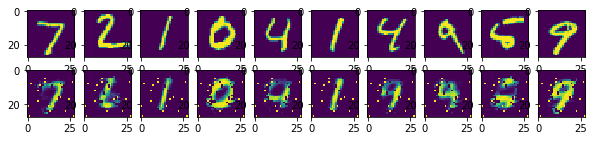

In [7]:
# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
plt.show()

可以发现，结果压缩、解压缩后。虽然图片的清晰度有所降低，但是依旧可以通过轮廓判断出具体的数值。

### 可视化压缩后的数据

建立包含四个隐层的神经网络，第一个隐层包含128个神经元，第二个隐层包含64个神经元，第三个包含10个神经元，第四个包含2个神经元。

将数据最终压缩为2维，方便可视化。


In [8]:
# Visualize encoder setting
# Parameters
learning_rate = 0.001    # 0.01 this learning rate will be better! Tested
training_epochs = 20
batch_size = 256
display_step = 1
# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
# hidden layer settings
n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 10
n_hidden_4 = 2

In [9]:
weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3],)),
    'encoder_h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4],)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_4, n_hidden_3],)),
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2],)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1],)),
    'decoder_h4': tf.Variable(tf.truncated_normal([n_hidden_1, n_input],)),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'encoder_b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b3': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b4': tf.Variable(tf.random_normal([n_input])),
}


In [11]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    layer_4 = tf.add(tf.matmul(layer_3, weights['encoder_h4']),
                                    biases['encoder_b4'])
    return layer_4
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                biases['decoder_b3']))
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['decoder_h4']),
                                biases['decoder_b4']))
    return layer_4


Epoch: 0001 cost= 0.092913218
Epoch: 0002 cost= 0.080139011
Epoch: 0003 cost= 0.071156956
Epoch: 0004 cost= 0.064683937
Epoch: 0005 cost= 0.064112440
Epoch: 0006 cost= 0.061396521
Epoch: 0007 cost= 0.059414875
Epoch: 0008 cost= 0.058107041
Epoch: 0009 cost= 0.056094486
Epoch: 0010 cost= 0.054418102
Epoch: 0011 cost= 0.054459941
Epoch: 0012 cost= 0.055078283
Epoch: 0013 cost= 0.053170443
Epoch: 0014 cost= 0.052285578
Epoch: 0015 cost= 0.050475314
Epoch: 0016 cost= 0.051494423
Epoch: 0017 cost= 0.049345504
Epoch: 0018 cost= 0.050678380
Epoch: 0019 cost= 0.049934182
Epoch: 0020 cost= 0.047889665
Optimization Finished!


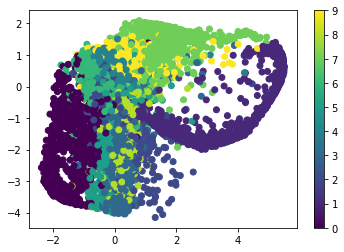

In [12]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")


    encoder_result = sess.run(encoder_op, feed_dict={X: mnist.test.images})
    plt.scatter(encoder_result[:, 0], encoder_result[:, 1], c=mnist.test.labels)
    plt.colorbar()
    plt.show()

颜色表示类别（不同的数值）。颜色表示类别（不同的数值）。可以看出，尽管有很大程度的混杂，但是还是有一定区分度的。